# Trabajo Practico - TSA

## Introduccion

Se escoje un dataset de kaggle que contiene el indice de vegetacion de 50k puntos distintos de sudamerica.

In [124]:
#%matplotlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa as tsa
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

In [2]:
PATH = r'C:\Users\agust\Documents'

In [3]:
DATASET = r'\Datasets\soybean_southamerica_mod13q1_evi_2000_2019.csv'

In [4]:
data = pd.read_csv(PATH+DATASET)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22850000 entries, 0 to 22849999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   fid        int64  
 1   date       object 
 2   timestamp  int64  
 3   evi        float64
dtypes: float64(1), int64(2), object(1)
memory usage: 697.3+ MB


Se toma aleatoriamente el field id 14880 para el desarrollo de este trabajo practico:

In [6]:
fid_14880 = data.where(data.fid==14880).dropna()

In [7]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 354 to 2280354
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fid        457 non-null    float64
 1   date       457 non-null    object 
 2   timestamp  457 non-null    float64
 3   evi        457 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.9+ KB


In [8]:
fid_14880.head()

,fid,date,timestamp,evi
354,14880.0,2000-02-18,9.508320e+11,0.4750
5354,14880.0,2000-03-05,9.522144e+11,0.3851
10354,14880.0,2000-03-21,9.535968e+11,0.4581
15354,14880.0,2000-04-06,9.549792e+11,0.3466
20354,14880.0,2000-04-22,9.563616e+11,0.3867


Se quitan las columnas fid y timestamp

In [9]:
fid_14880.drop(labels=['fid', 'timestamp'], axis=1, inplace=True)

Se convierte la columna Date en tipo 'datetime'

In [10]:
fid_14880['date'] = pd.to_datetime(fid_14880['date'], format="%Y-%m-%d")

In [11]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 354 to 2280354
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    457 non-null    datetime64[ns]
 1   evi     457 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 KB


In [12]:
fid_14880.head()

,date,evi
354,2000-02-18,0.4750
5354,2000-03-05,0.3851
10354,2000-03-21,0.4581
15354,2000-04-06,0.3466
20354,2000-04-22,0.3867


In [13]:
fid_14880.tail()

,date,evi
2260354,2019-10-16,0.3244
2265354,2019-11-01,0.3315
2270354,2019-11-17,0.5639
2275354,2019-12-03,0.5876
2280354,2019-12-19,0.6166


In [14]:
fid_14880.describe()

,evi
count,457.000000
mean,0.408142
std,0.087391
min,0.182400
25%,0.347100
50%,0.404700
75%,0.465900
max,0.773800


## Punto 1:
* Graficar una serie a partir de un dataset relevante. Explicar observaciones.

<AxesSubplot:xlabel='date'>

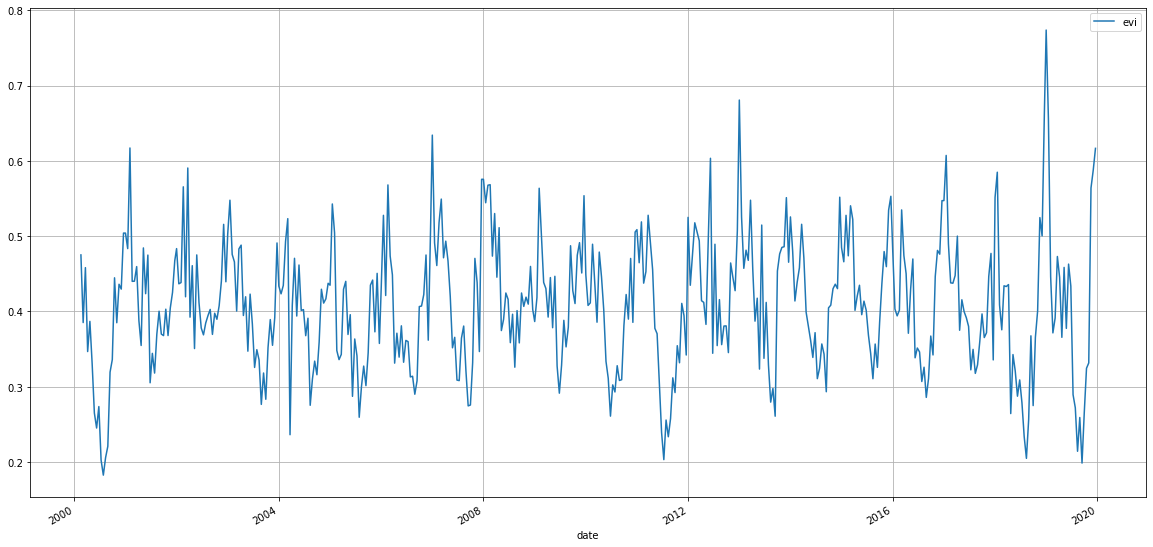

In [15]:
fid_14880.plot(x='Date',y='EVI',figsize=(20,10), grid=True)

<AxesSubplot:ylabel='Frequency'>

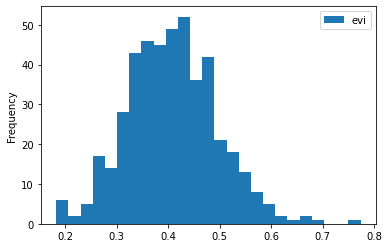

In [16]:
fid_14880.plot(x='date',y='evi', kind='hist', bins = 25)

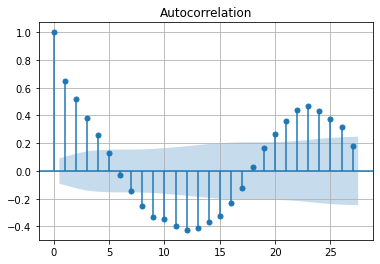

In [17]:
plot_acf(fid_14880.evi.values)
plt.grid(True)
plt.show()

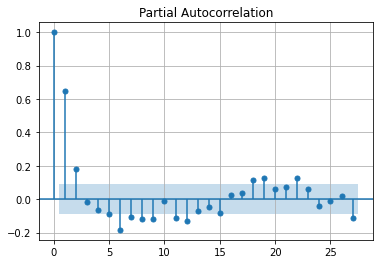

In [18]:
plot_pacf(fid_14880.evi.values)
plt.grid(True)
plt.show()

La serie de tiempo elegida muestra la evolucion del indice de cultivo entre los periodos de febrero del 2000 y diciembre del 2019.

Se puede observar un comportamiento periodico y dada la naturaleza del dataset se puede suponer que depende de los ciclos del cultivos, con un periodo observable que pareceria ser cada 12 meses.

Se puede diferencial cada periodo a pesar de ser una señal muy ruidosa.

A partir de su autocorrelacion podemos ver que no es estacionaria.

## Punto 2:
* Descomponer una serie de tiempo usando el modelo aditivo y el modelo multiplicativo.

La descompocision se realiza de tal modo que nos queden los siguientes modelos:

Modelo Aditivo:

    Y(t) = T(t) + S(t) + C(t) + e(t)

Modelo Multiplicativo:

    Y(t) = T(t) * S(t) * C(t) * e(t)

Con:

T(t): tendencia.
S(t): variación estacional.
C(t): Componente cíclico.
e(t): Componente aleatoria.

En un primer paso utilizaremos la funcion seasonal_descompose de la libreria statsmodels. Esta funcion nos devolvera ambos modelos antes descriptos, sin considerar la componente ciclica. Modelos de la funcion seasonal_descompose:
   * The additive model is Y[t] = T[t] + S[t] + e[t]
   * The multiplicative model is Y[t] = T[t] * S[t] * e[t]
   
Los parametros de esta funcion son:
   * Los valores de la serie de tiepo en cuestion
   * El tipo de modelo a calcular
   * El periodo de la serie. En este caso el periodo es 21, ya que de la visualizacion de la grafica se desprende que hay un ciclo por año.

In [19]:
fid_14880_2 = fid_14880
fid_14880_2 = fid_14880_2.set_index(pd.DatetimeIndex(fid_14880_2['date']))
fid_14880_2.sort_index(ascending=True, inplace=True)
fid_14880_2 = fid_14880_2['evi']

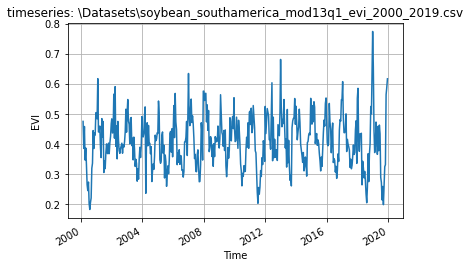

In [20]:
fid_14880_2.plot()
plt.title("timeseries: " + DATASET)
plt.xlabel("Date")
plt.ylabel("EVI")
plt.grid()
plt.show()

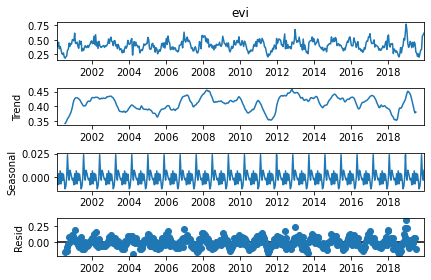

In [21]:
# Additive
addit = sm.tsa.seasonal_decompose(fid_14880_2, model='additive', period = 20)
addit.plot()
plt.show()

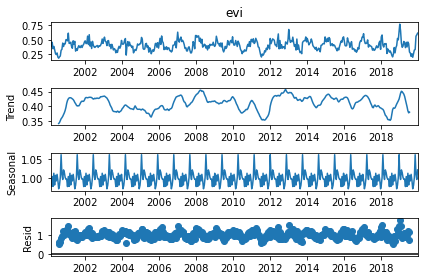

In [22]:
# Multiplicative
mult = sm.tsa.seasonal_decompose(fid_14880_2, model='multiplicative', period = 20)
mult.plot()
plt.show()

## Punto 3:
* Aplicar los modelos vistos en clase:
    - Para la tendencia usar cuadrados mínimos y expresar los coeficientes. Sacar conclusiones acerca de la validez del modelo
    - Componente cíclica: usar análisis espectral y hallar las frecuencias principales
    - Para la componente estacional usar ARIMA
    - Para la componente de error obtener R_k, C_k

##### Calculo de la tendencia como funcion cuadratica

A continuacion se estimara la tendencia como una funcion cuadtratica: 

In [23]:
def objective(t,a,b,c):
    return a*t**2+b*t+c

In [24]:
x = fid_14880.date.values

In [25]:
x = pd.to_numeric(fid_14880['date']).values

In [26]:
y = fid_14880.evi.values

In [27]:
x = (x-x.min())/(x.max()-x.min())

In [28]:
popt, _ = curve_fit(objective, x, y)
a,b,c = popt

Parametros de T(t) = a t^2 + b t + c

In [29]:
print('a:', a)
print('b:', b)
print('c:', c)

a: -0.09052178160947655
b: 0.10666080174568526
c: 0.38501384871166233


In [30]:
y_tend = objective(x,a,b,c)

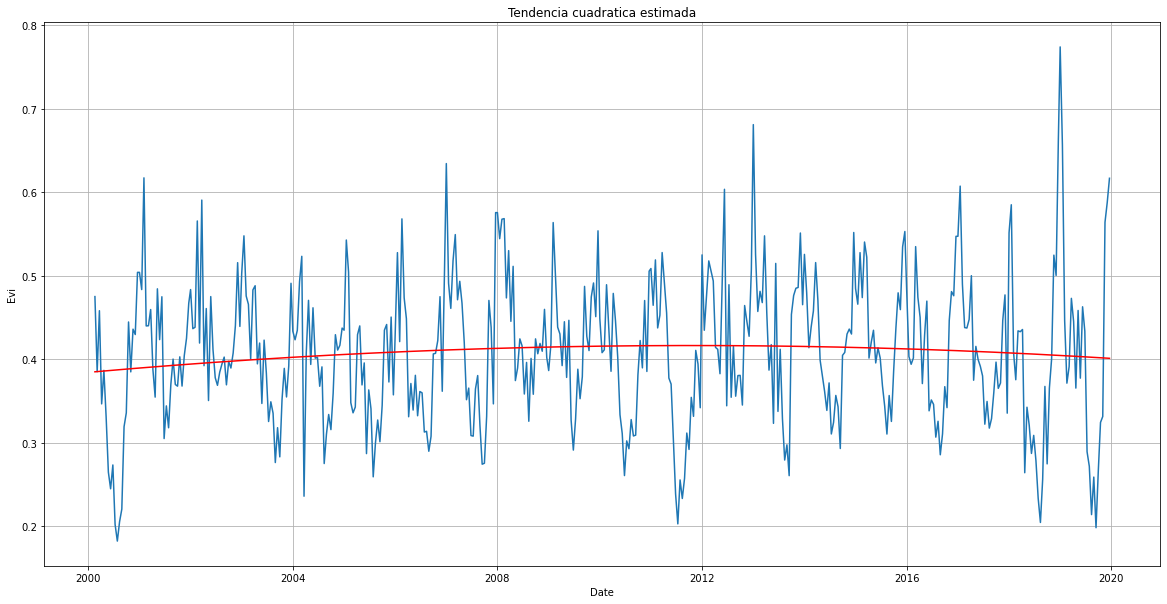

In [58]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values, y)
ax.plot(fid_14880['date'].values,y_tend, color = 'red')
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Evi")
ax.grid(True)
plt.show()

#### Metodo de cuadrados minimos

In [32]:
Q = y - y_tend

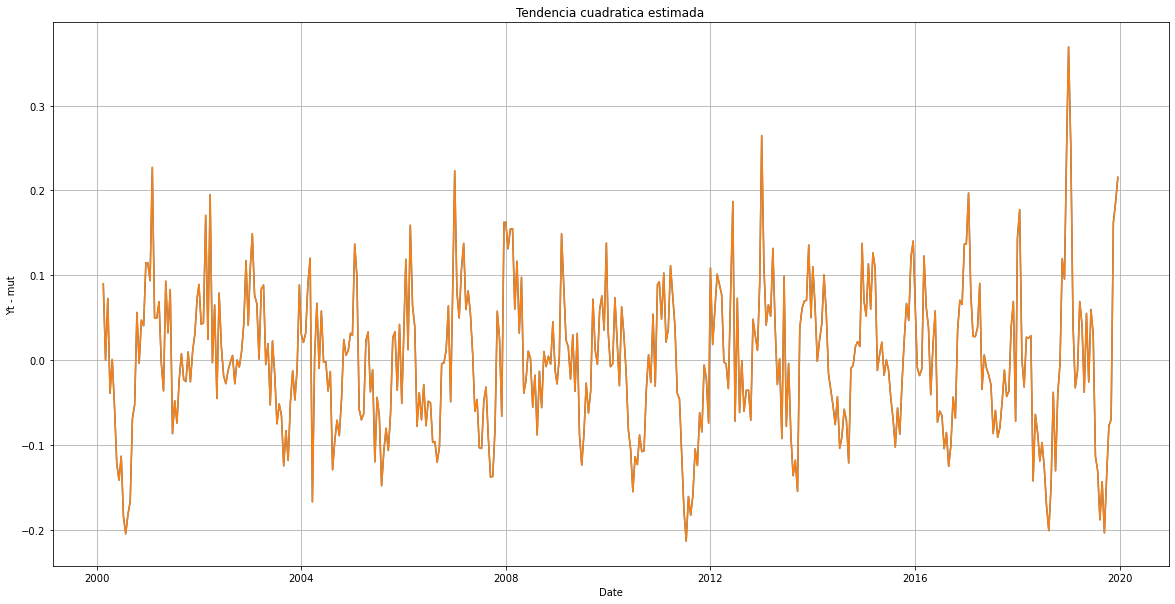

In [57]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values, Q)
ax.plot(fid_14880['date'].values,Q)
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Yt - mut")
ax.grid(True)
plt.show()

In [34]:
print("Media : ",np.mean(Q))
print("Varianza : ",np.std(Q)**2)

Media :  6.582813798073354e-12
Varianza :  0.007552825395942476


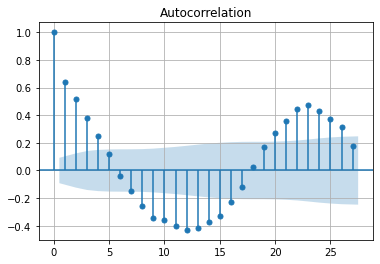

In [35]:
plot_acf(Q)
plt.grid(True)
plt.show()

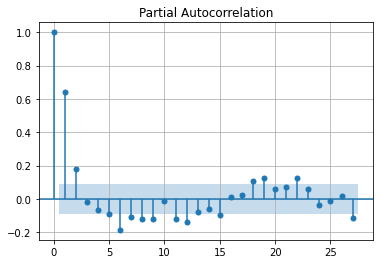

In [36]:
plot_pacf(Q)
plt.grid(True)
plt.show()

#### Frecuencias principales

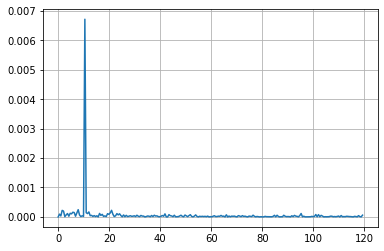

In [116]:
G, Pyy_den = signal.periodogram(y, 239)
plt.plot(G, Pyy_den)
plt.grid()
plt.show()

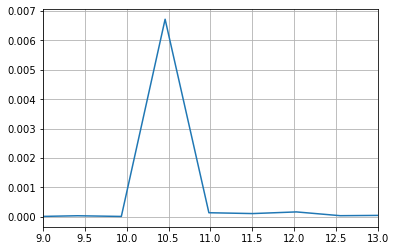

In [119]:
G, Pyy_den = signal.periodogram(y, 239)
plt.plot(G, Pyy_den)
plt.grid()
plt.xlim(9,13)
plt.show()

#### Calculo de componente ciclica

Calcularemos esta componente despejando Y(t) de los modelos:

Modelo Aditivo:

    Y(t) = T(t) + S(t) + C(t) + e(t)

Modelo Multiplicativo:

    Y(t) = T(t) * S(t) * C(t) * e(t)
    
Y(t) es dato, nuestra serie de tiempo
T(t), S(t), e(t) fueron provistos por la funcion seasonal_decompose.

Calcularemos la componente ciclica para la funcion de tendencia cuadratica y la funcion dada por seasonal_decompose.

In [79]:
# Modelo aditivo
Ct_add = fid_14880_2.values - y_tend - addit.seasonal - addit.resid.fillna(0)

# Modelo multiplicativo
Ct_mult = fid_14880_2.values / y_tend / mult.seasonal / mult.resid.fillna(1)

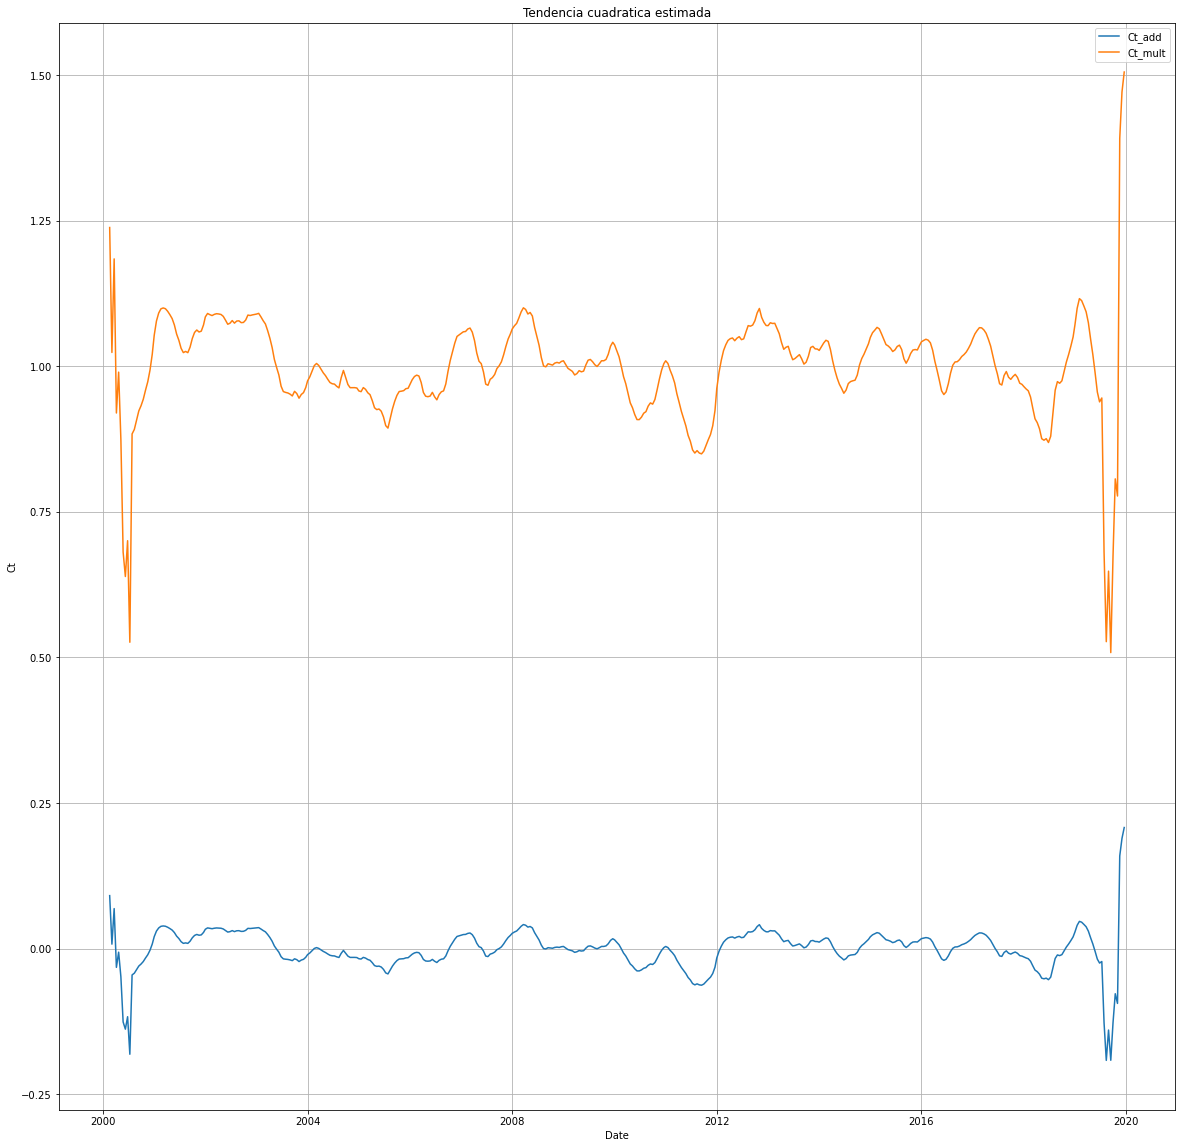

In [80]:
fig, ax = plt.subplots(1,figsize=(20, 20))
ax.plot(fid_14880['date'].values, Ct_add)
ax.plot(fid_14880['date'].values, Ct_mult)
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Ct")
ax.legend(['Ct_add', 'Ct_mult'])
ax.grid(True)
plt.show()

#### Calculo componente estacional e implementacion de ARIMA

In [108]:
evi_estacional = y - Ct_add.values - y_tend

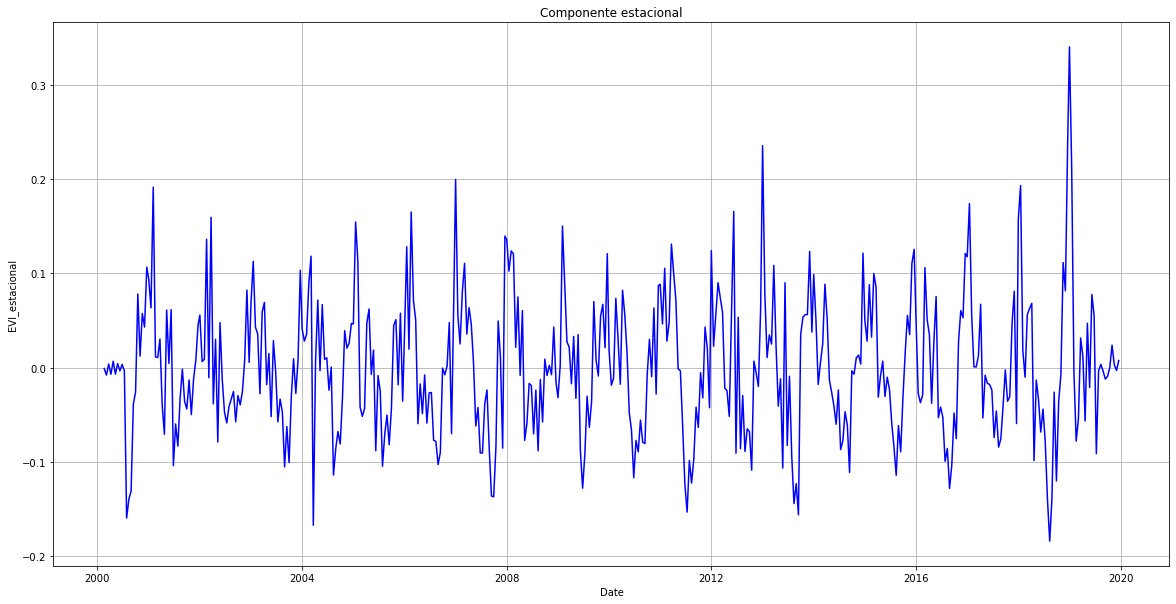

In [109]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,St, color = 'blue')
ax.set_title("Componente estacional")
ax.set_xlabel("Date")
ax.set_ylabel("EVI_estacional")
ax.grid(True)
plt.show()

In [110]:
print("Media : ",np.mean(evi_estacional))
print("Varianza : ",np.std(evi_estacional)**2)

Media :  0.000597058171587692
Varianza :  0.005284458079385613


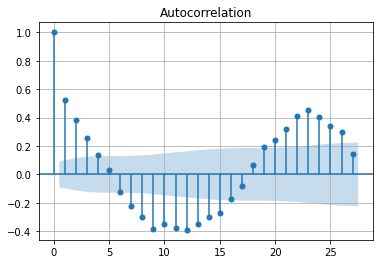

In [111]:
plot_acf(evi_estacional)
plt.grid(True)
plt.show()

In [112]:
evi_diff1 = evi_estacional[1:] - evi_estacional[:-1]

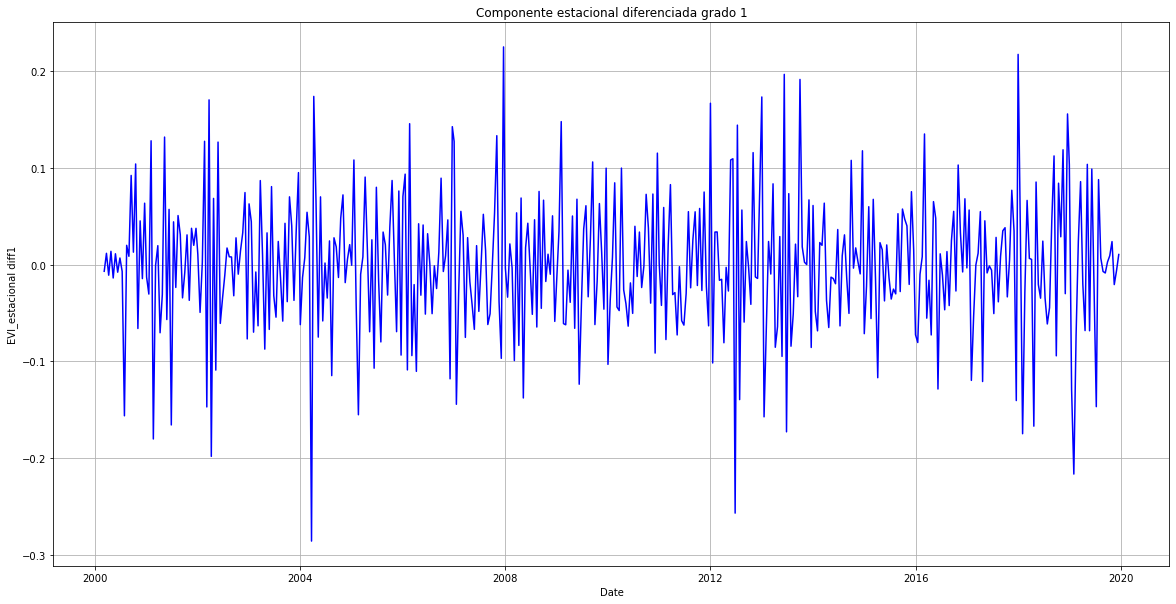

In [113]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values[1:],evi_diff1, color = 'blue')
ax.set_title("Componente estacional diferenciada grado 1")
ax.set_xlabel("Date")
ax.set_ylabel("EVI_estacional diff1")
ax.grid(True)
plt.show()

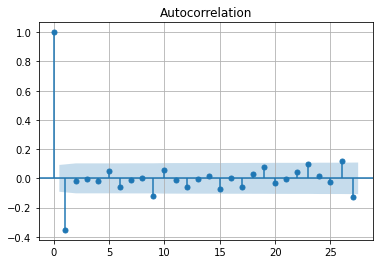

In [114]:
plot_acf(evi_diff1)
plt.grid(True)
plt.show()

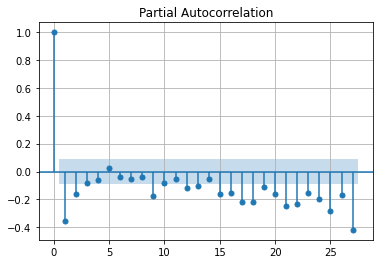

In [122]:
plot_pacf(evi_diff1)
plt.grid(True)
plt.show()

El orden del parametro AR (p) lo estableceremos en funcion de la autocorrelacion parcial, y el orden del parametro MA (q) lo elegiremos a partir de la autocorrelacion. Por lo tanto se popone:
   * p = 3
   * q = 2

In [202]:
arima_0 = ARIMA(evi_estacional,order=(3,1,2))
model_fit_0 = arima_0.fit()
print(model_fit_0.summary())

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  457
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 622.852
Date:                Mon, 13 Dec 2021   AIC                          -1233.704
Time:                        23:46:30   BIC                          -1208.969
Sample:                             0   HQIC                         -1223.960
                                - 457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5394      0.068     -7.937      0.000      -0.673      -0.406
ar.L2          0.5906      0.059     10.034      0.000       0.475       0.706
ar.L3          0.1424      0.047      3.003      0.0

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


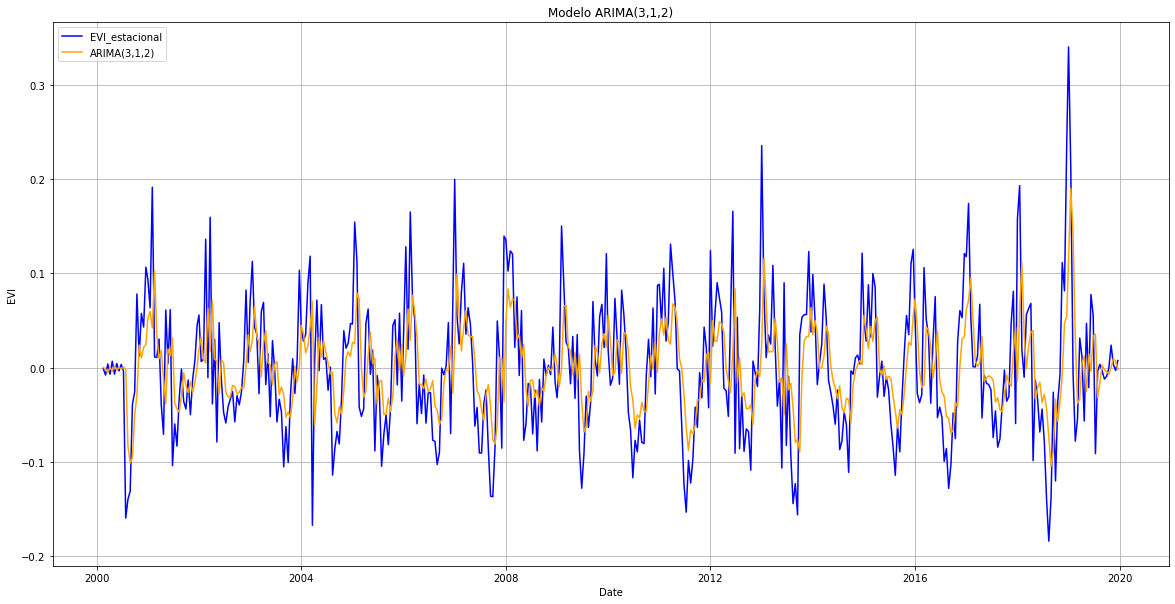

In [203]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,evi_estacional, color = 'blue')
ax.plot(fid_14880['date'].values,model_fit_0.fittedvalues, color = 'orange')
ax.set_title("Modelo ARIMA(3,1,2)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'ARIMA(3,1,2)'])
ax.grid(True)
plt.show()

In [191]:
arima_1 = ARIMA(evi_estacional,order=(5,2,2))
model_fit_1 = arima_1.fit()
print(model_fit_1.summary())

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  457
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 590.819
Date:                Mon, 13 Dec 2021   AIC                          -1165.637
Time:                        23:41:42   BIC                          -1132.675
Sample:                             0   HQIC                         -1152.651
                                - 457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3970      0.089    -15.766      0.000      -1.571      -1.223
ar.L2         -0.6181      0.090     -6.842      0.000      -0.795      -0.441
ar.L3         -0.2972      0.099     -2.987      0.0

C:\Users\agust\anaconda3\envs\CEIA\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


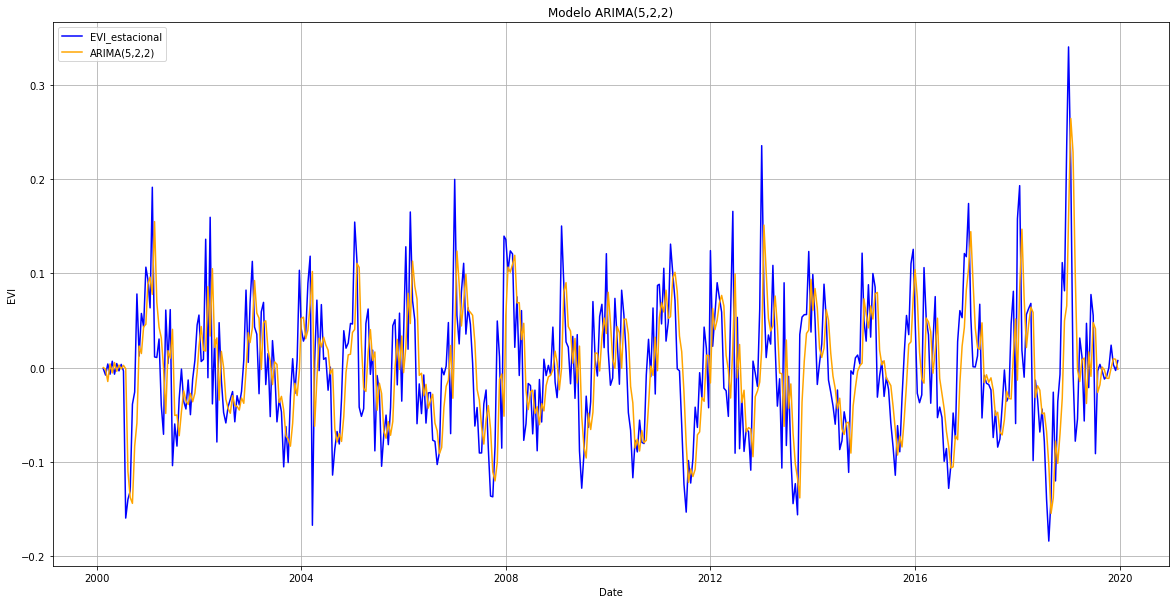

In [192]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,evi_estacional, color = 'blue')
ax.plot(fid_14880['date'].values,model_fit_1.fittedvalues, color = 'orange')
ax.set_title("Modelo ARIMA(5,2,2)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'ARIMA(5,2,2)'])
ax.grid(True)
plt.show()

In [193]:
arima_2 = ARIMA(evi_estacional,order=(3,1,0))
model_fit_2 = arima_2.fit()
print(model_fit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  457
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 594.952
Date:                Mon, 13 Dec 2021   AIC                          -1181.905
Time:                        23:41:42   BIC                          -1165.415
Sample:                             0   HQIC                         -1175.409
                                - 457                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4214      0.039    -10.690      0.000      -0.499      -0.344
ar.L2         -0.1924      0.046     -4.204      0.000      -0.282      -0.103
ar.L3         -0.0817      0.044     -1.839      0.0

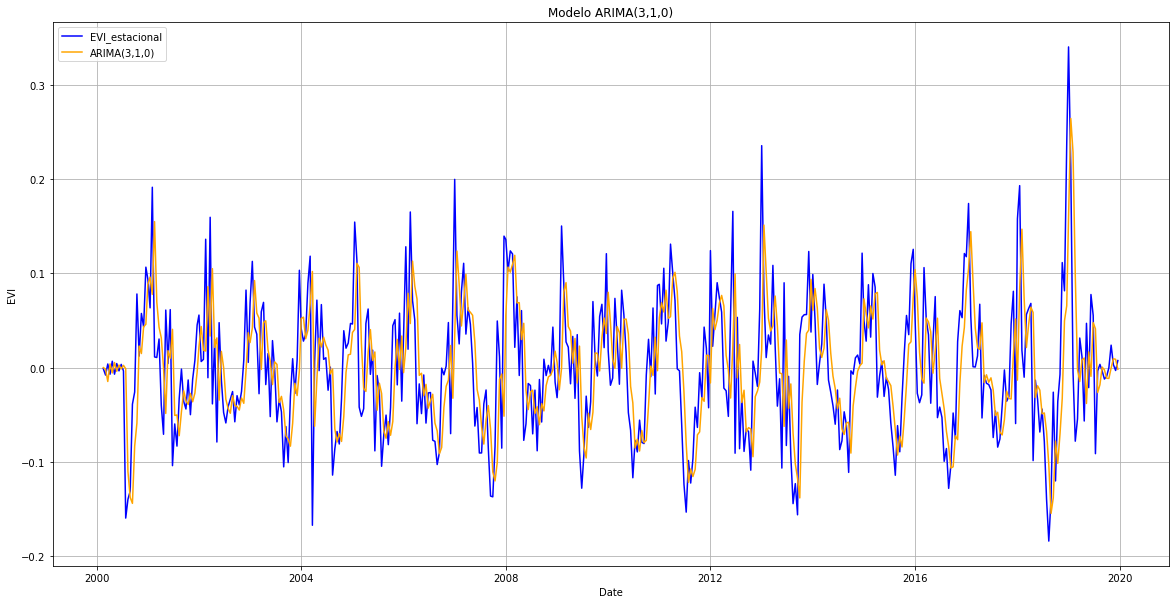

In [194]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(fid_14880['date'].values,evi_estacional, color = 'blue')
ax.plot(fid_14880['date'].values,model_fit.fittedvalues, color = 'orange')
ax.set_title("Modelo ARIMA(3,1,0)")
ax.set_xlabel("Date")
ax.set_ylabel("EVI")
ax.legend(['EVI_estacional', 'ARIMA(3,1,0)'])
ax.grid(True)
plt.show()

Como podemos ver los parametros del ARIMA(5,2,2) tienen mayor dispersion que el ARIMA(3,1,0), siendo estos dos mas precisos que el ARIMA(3,1,2).

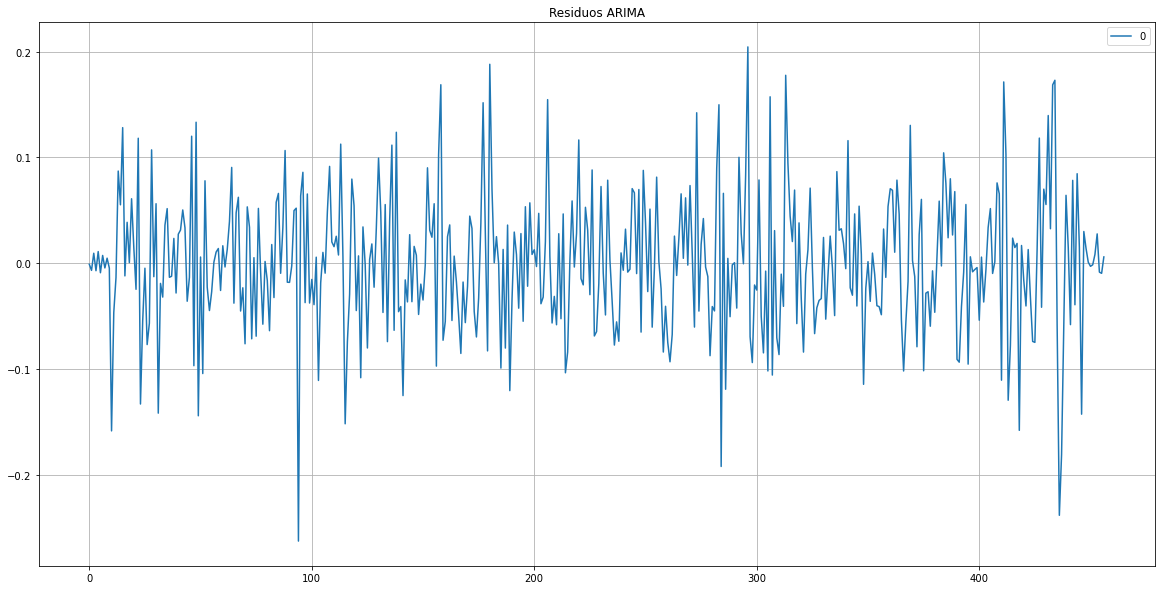

In [207]:
residuals = pd.DataFrame(model_fit_2.resid)
residuals.plot(figsize = (20,10))
plt.title('Residuos ARIMA')
plt.grid()
plt.show()

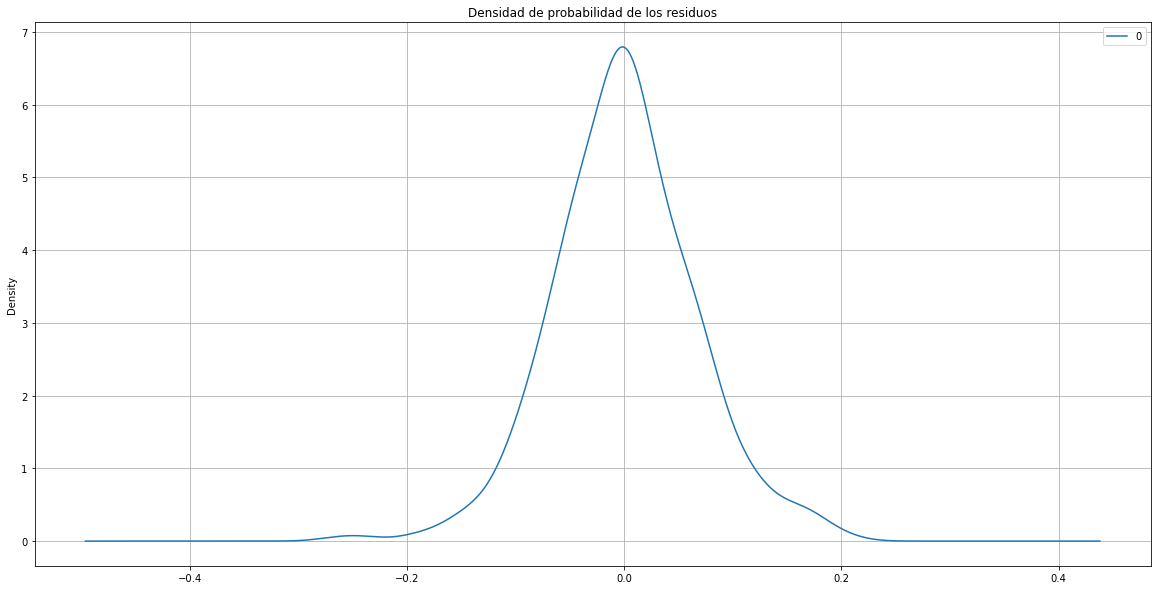

In [213]:
# density plot of residuals
residuals.plot(kind='kde',figsize = (20,10))
plt.title("Densidad de probabilidad de los residuos")
plt.grid()
plt.show()

In [211]:
# summary stats of residuals
print(residuals.describe())

                0
count  457.000000
mean     0.000022
std      0.065620
min     -0.262709
25%     -0.040842
50%     -0.001615
75%      0.038036
max      0.204360


## Punto 4:
* Predicciones:
    - Realizar predicciones usando (S)ARIMA
    - Realizar predicciones usando redes neuronales LSTM
    - Extraer conclusiones